In [5]:
# data utilities
import numpy as np
import pandas as pd
from scipy import stats

# plotting utilities
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import plotly.express as px

# machine learning utilities
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer, TransformedTargetRegressor, ColumnTransformer
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN

import warnings
warnings.filterwarnings("ignore")

In [6]:
cars = pd.read_csv('data/vehicles.csv')
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

# Remove unecessary columns
These columns are essentially are identifiers that duplicate the index.

In [7]:
cars.drop(columns=['id', 'VIN'], inplace=True)

In [8]:
# drop columns with difficult values
cars.drop(columns=['model', 'region'], inplace=True)

In [9]:
cars.dropna(inplace=True)
cars.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80170 entries, 31 to 426836
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         80170 non-null  int64  
 1   year          80170 non-null  float64
 2   manufacturer  80170 non-null  object 
 3   condition     80170 non-null  object 
 4   cylinders     80170 non-null  object 
 5   fuel          80170 non-null  object 
 6   odometer      80170 non-null  float64
 7   title_status  80170 non-null  object 
 8   transmission  80170 non-null  object 
 9   drive         80170 non-null  object 
 10  size          80170 non-null  object 
 11  type          80170 non-null  object 
 12  paint_color   80170 non-null  object 
 13  state         80170 non-null  object 
dtypes: float64(2), int64(1), object(11)
memory usage: 9.2+ MB


<Axes: xlabel='odometer', ylabel='price'>

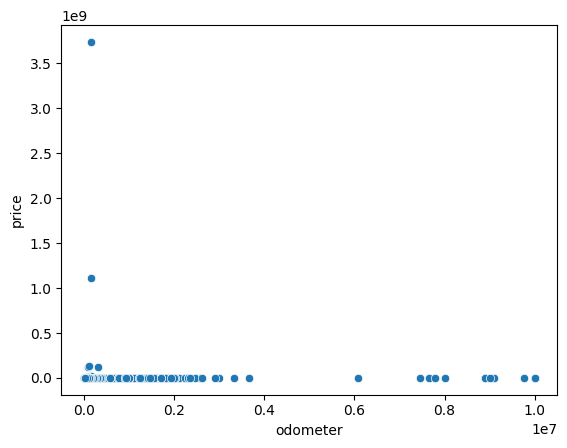

In [10]:
sns.scatterplot(data=cars, x='odometer', y='price')

In [11]:
cars = cars.query('price > 0 and price < 80_000 and odometer < 500_000')
cars.info()

<class 'pandas.core.frame.DataFrame'>
Index: 76289 entries, 31 to 426833
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         76289 non-null  int64  
 1   year          76289 non-null  float64
 2   manufacturer  76289 non-null  object 
 3   condition     76289 non-null  object 
 4   cylinders     76289 non-null  object 
 5   fuel          76289 non-null  object 
 6   odometer      76289 non-null  float64
 7   title_status  76289 non-null  object 
 8   transmission  76289 non-null  object 
 9   drive         76289 non-null  object 
 10  size          76289 non-null  object 
 11  type          76289 non-null  object 
 12  paint_color   76289 non-null  object 
 13  state         76289 non-null  object 
dtypes: float64(2), int64(1), object(11)
memory usage: 8.7+ MB


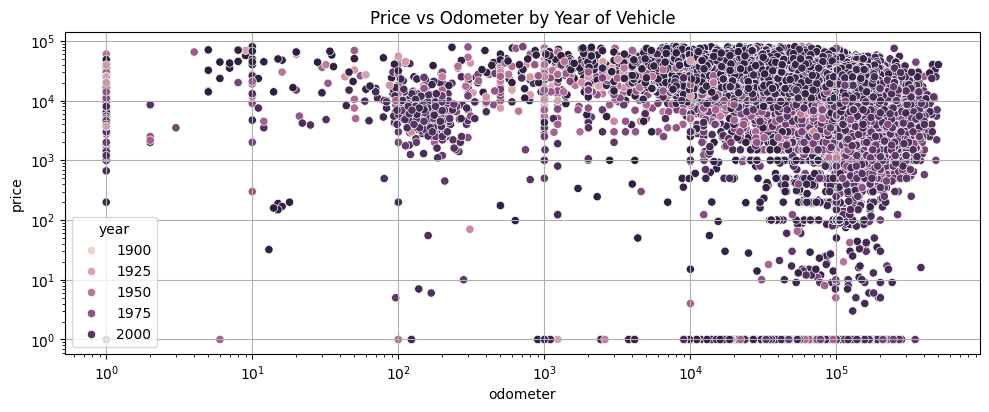

In [15]:
fig = plt.figure(figsize=(10,4))
sns.scatterplot(data=cars, x='odometer', y='price', hue='year')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
fig.tight_layout()
plt.title('Price vs Odometer by Year of Vehicle')
plt.show()

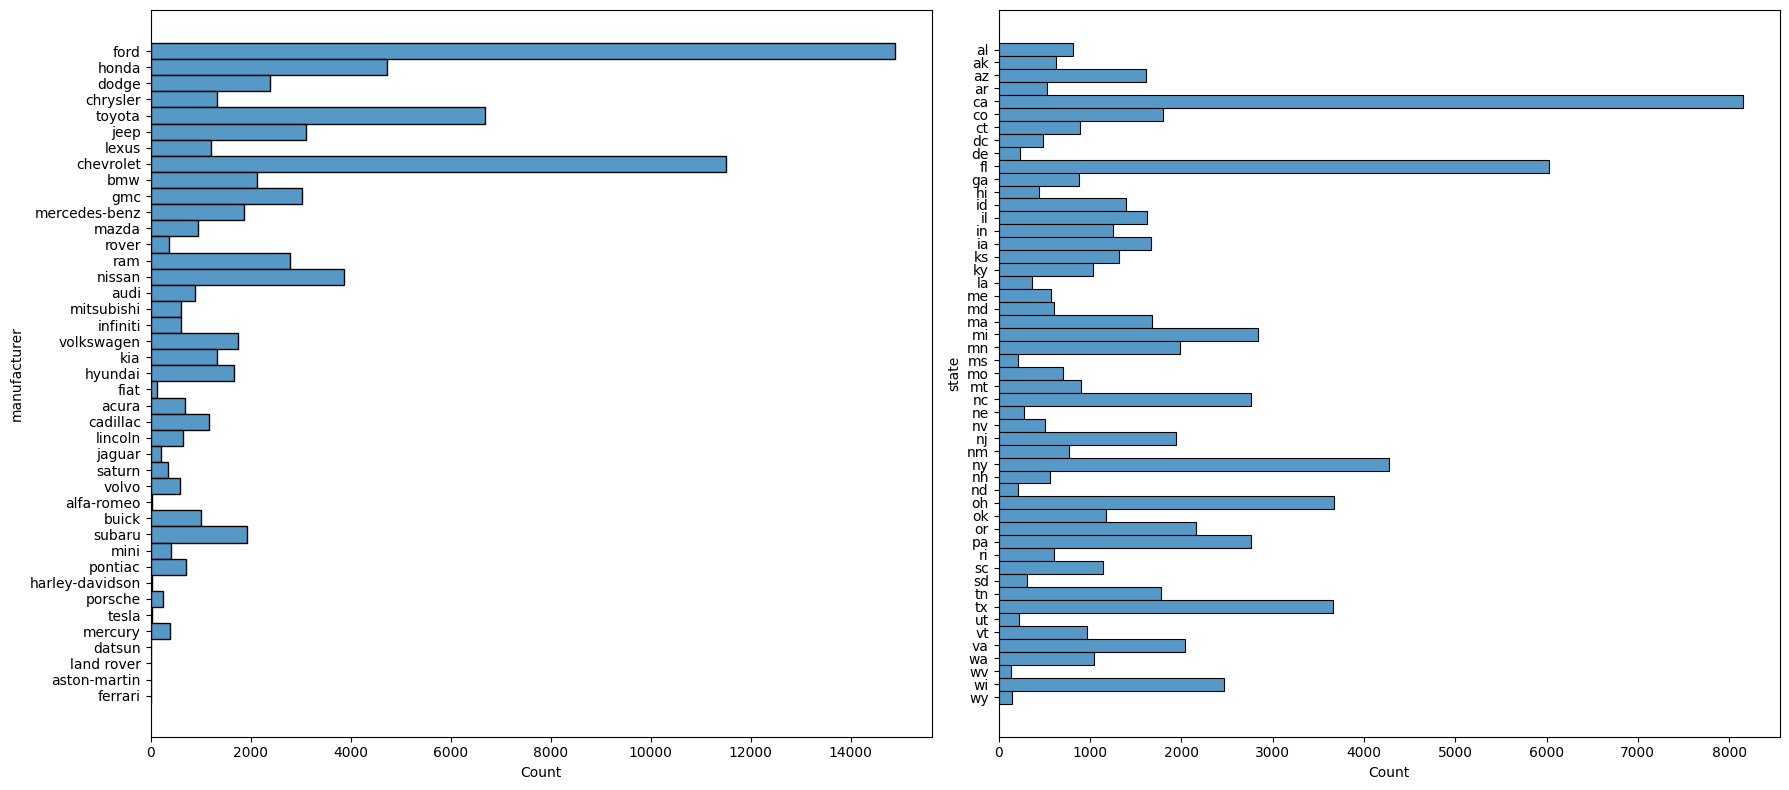

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(18,8))
sns.histplot(ax=ax[0], data = cars, y='manufacturer')
sns.histplot(ax=ax[1], data = cars, y='state')
fig.tight_layout()
plt.show()

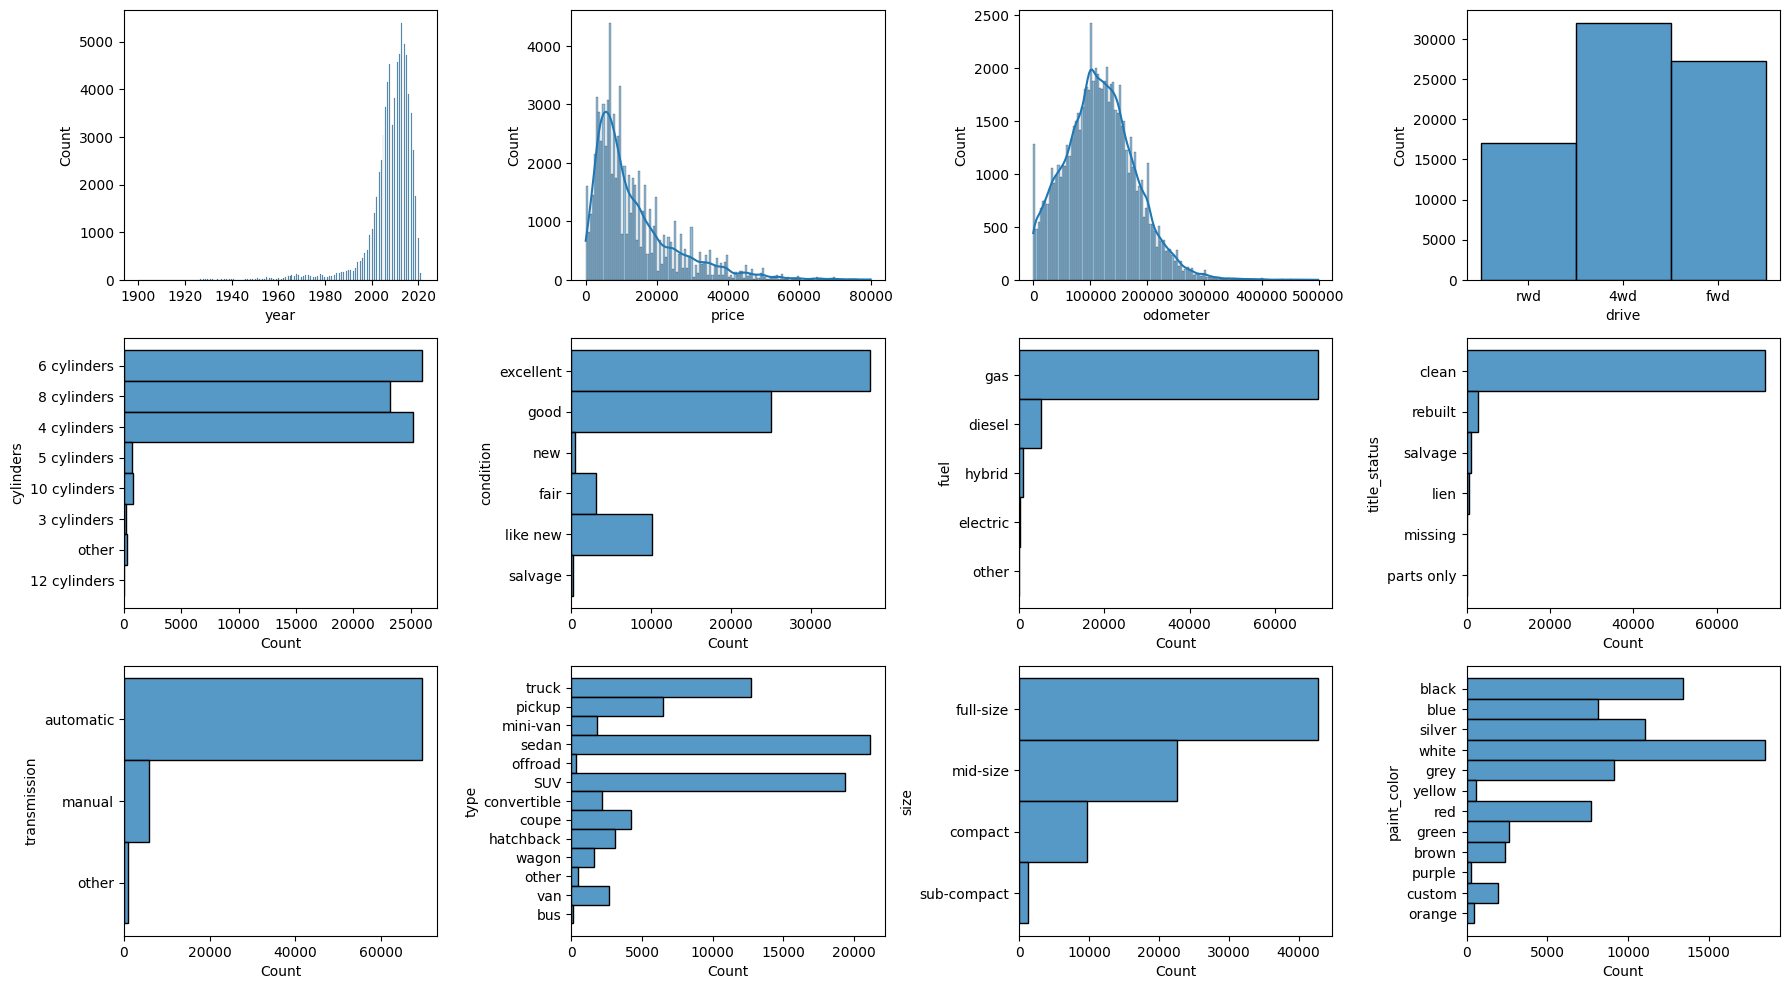

In [20]:
fig, ax = plt.subplots(3, 4, figsize=(18,10))
sns.histplot(ax = ax[0][0], data=cars, x='year')
sns.histplot(ax = ax[0][1], data=cars, x='price', kde=True)
sns.histplot(ax = ax[0][2], data=cars, x='odometer', kde=True)
sns.histplot(ax = ax[0][3], data=cars, x='drive')

sns.histplot(ax = ax[1][0], data=cars, y='cylinders')
sns.histplot(ax = ax[1][1], data=cars, y='condition')
sns.histplot(ax = ax[1][2], data=cars, y='fuel')
sns.histplot(ax = ax[1][3], data=cars, y='title_status')

sns.histplot(ax = ax[2][0], data=cars, y='transmission')
sns.histplot(ax = ax[2][1], data=cars, y='type')
sns.histplot(ax = ax[2][2], data=cars, y='size')
sns.histplot(ax = ax[2][3], data=cars, y='paint_color')

fig.tight_layout()
plt.show()


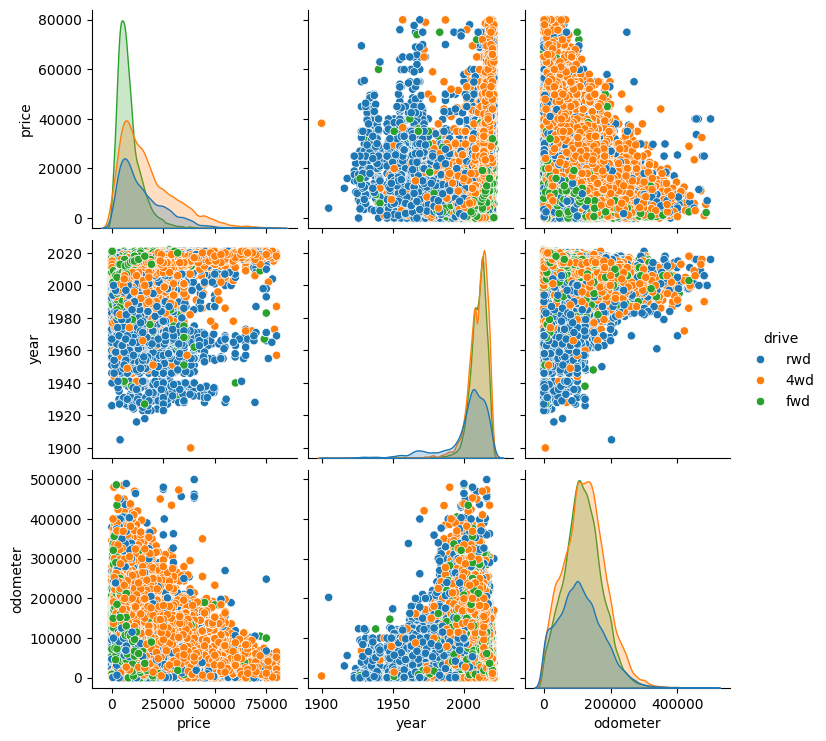

In [31]:
sns.pairplot(cars, hue='drive')

# Helper functions
Don't repeat yourself

In [32]:
def train_and_evaluate_model(model, name, X, y):
  # split the data into training and test data sets
  X_train, X_test, y_train, y_test = train_test_split(X, y)

  # train the model
  model.fit(X, y)

  # evaluate the model
  mse_train = mean_squared_error(model.predict(X_train), y_train)
  mse_test = mean_squared_error(model.predict(X_test), y_test)

  # report on the correlation coefficient (R2 score)
  r2_train = model.score(X_train, y_train)
  r2_test = model.score(X_test, y_test)

  print(f'MSE on {name} training data set', mse_train)
  print(f'MSE on {name} test data set', mse_test)
  print(f'R2 on {name} training data set', r2_train)
  print(f'R2 on {name} test data set', r2_test)

  return mse_train, mse_test, r2_train, r2_test

# Simple model

In [33]:
pipe = Pipeline([
  ('poly', PolynomialFeatures(degree=2, include_bias = False)),
  ('scale', StandardScaler()),
  ('linreg', LinearRegression()),
])
pipe

Pipeline(steps=[('poly', PolynomialFeatures(include_bias=False)),
                ('scale', StandardScaler()), ('linreg', LinearRegression())])

In [34]:
mse_num_train, mse_num_test, r2_num_train, r2_num_test = \
  train_and_evaluate_model(pipe, 'simple', cars[['year', 'odometer']], cars['price'])


MSE on simple training data set 94322612.88930413
MSE on simple test data set 95694197.33220318
R2 on simple training data set 0.3201470042405614
R2 on simple test data set 0.31769214658842737


# With Categorical Features

In [35]:
cat_features = cars.select_dtypes(include='object').columns.to_list()
num_features = cars.select_dtypes(include='number').columns.drop(['price']).to_list()
fearures = cat_features+num_features
fearures

['manufacturer',
 'condition',
 'cylinders',
 'fuel',
 'title_status',
 'transmission',
 'drive',
 'size',
 'type',
 'paint_color',
 'state',
 'year',
 'odometer']

In [36]:
preprocessor = ColumnTransformer(
  transformers=[
    ('cat_features', OneHotEncoder(drop = 'if_binary', handle_unknown = 'ignore'), cat_features ),
    (
      'num_features',
      make_pipeline(
        PolynomialFeatures(degree=2, include_bias = False),
        StandardScaler(),
      ),
      num_features
    ),
  ]
)
pipe = Pipeline([
  ('preprocessor', preprocessor),
  ('linreg', LinearRegression()),
])
pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat_features',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'),
                                                  ['manufacturer', 'condition',
                                                   'cylinders', 'fuel',
                                                   'title_status',
                                                   'transmission', 'drive',
                                                   'size', 'type',
                                                   'paint_color', 'state']),
                                                 ('num_features',
                                                  Pipeline(steps=[('polynomialfeatures',
                                                                   PolynomialFeatures(include_bias=False)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['year', 'odometer'])])),
                ('linreg', LinearRegression())])

In [37]:
mse_full_train, mse_full_test, r2_full_train, r2_full_test = \
  train_and_evaluate_model(pipe, 'full', cars[fearures], cars['price'])

MSE on full training data set 45815014.986099236
MSE on full test data set 45664034.64103171
R2 on full training data set 0.669908219753266
R2 on full test data set 0.6740118309617682


# With Feature Selection

In [38]:
pipe = Pipeline([
  ('preprocessor', preprocessor),
  ('selector', SelectFromModel(Lasso())),
  ('linereg', LinearRegression()),
])
pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat_features',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'),
                                                  ['manufacturer', 'condition',
                                                   'cylinders', 'fuel',
                                                   'title_status',
                                                   'transmission', 'drive',
                                                   'size', 'type',
                                                   'paint_color', 'state']),
                                                 ('num_features',
                                                  Pipeline(steps=[('polynomialfeatures',
                                                                   PolynomialFeatures(include_bias=False)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['year', 'odometer'])])),
                ('selector', SelectFromModel(estimator=Lasso())),
                ('linereg', LinearRegression())])

In [39]:
mse_selected_train, mse_selected_test, r2_selected_train, r2_selected_test = \
  train_and_evaluate_model(pipe, 'full', cars[fearures], cars['price'])

MSE on full training data set 45957527.15910216
MSE on full test data set 45305438.84352292
R2 on full training data set 0.6705820584585729
R2 on full test data set 0.6715787064167058


In [40]:
# hyper parameter
n = 25
params_dict = {
  'selector__estimator__alpha': np.logspace(-5, 2, n),  # alphas to try in the Lasso feature selection step,
}

# k-fold validation
k = 3 # reasonable value, large data set, just want to train on all data

# define the data set to use
X, y = cars[fearures], cars['price']

# perform k-fold cross-validation
finder = GridSearchCV(
  estimator=pipe,
  param_grid=params_dict,
  scoring='neg_mean_squared_error',
  cv=k,
)
finder.fit(X, y)  # use the entire set
best_model = finder.best_estimator_

print('Best selector alpha:', best_model.get_params()['selector__estimator__alpha'])

mse_best_train, mse_best_test, r2_best_train, r2_best_test = \
  train_and_evaluate_model(best_model, 'best', X, y)

Best selector alpha: 0.908517575651688
MSE on best training data set 45331039.726167835
MSE on best test data set 47183801.59468485
R2 on best training data set 0.6723525125936849
R2 on best test data set 0.6663635495223238


# Grid Search
- lasso parameter
- ridge regression parameter

In [ ]:
# hyper parameter
n = 10
params_dict = {
  'selector__estimator__alpha': np.logspace(-5, 5, n),  # alphas to try in the Lasso feature selection step,
  'ridge__alpha': np.logspace(-5, 5, n)  # alphas to try in the Lasso feature selection step,
}

# k-fold validation
k = 4 # reasonable value, large data set, just want to train on all data

# define the data set to use
X, y = cars[fearures], cars['price']

# perform k-fold cross-validation
finder = GridSearchCV(
  estimator=pipe,
  param_grid=params_dict,
  scoring='neg_mean_squared_error',
  cv=k,
)
finder.fit(X, y)  # use the entire set
best_model = finder.best_estimator_

coefs= best_model.named_steps['selector'].estimator.coef_

mse_best_train, mse_best_test, r2_best_train, r2_best_test = \
  train_and_evaluate_model(best_model, 'full', X, y)

MSE on full training data set 45083440.3452717
MSE on full test data set 38982154.61366085
R2 on full training data set 0.6812894936166132
R2 on full test data set 0.7151030866883461


In [ ]:
pd.DataFrame(
  {
    'MSE train': np.array([mse_num_train, mse_full_train, mse_selected_train, mse_best_train]),
    'MSE test': np.array([mse_num_test, mse_full_test, mse_selected_test, mse_best_test]),
    'R2 train': np.array([r2_num_train, r2_full_train, r2_selected_train, r2_best_train]),
    'R2 test': np.array([r2_num_test, r2_full_test, r2_selected_test, r2_best_test]),
  },
  index=['simple', 'full', 'selected', 'best']
)

,MSE train,MSE test,R2 train,R2 test
simple,9.589795e+07,9.842085e+07,0.305248,0.308782
full,4.789854e+07,4.800171e+07,0.656116,0.653694
selected,4.781640e+07,4.829428e+07,0.654774,0.657391
best,3.137961e+07,2.875998e+07,0.760948,0.767476


In [ ]:
best_selector_alpha = float(best_model.get_params()['selector__estimator__alpha'])
best_ridge_alpha = float(best_model.get_params()['ridge__alpha'])

best_selector_alpha, best_ridge_alpha

(0.005994842503189409, 0.0001)

### Plot the curve

In [ ]:
# TODO plot the mse curves
len([(sa, ra) for sa in params_dict['selector__estimator__alpha'] for ra in params_dict['ridge__alpha']])

25

# DBScan

In [ ]:
pipe = Pipeline([
  ('preprocessor', preprocessor),
  # ('selector', SelectFromModel(Lasso(alpha=best_selector_alpha))),
  ('pca', PCA(n_components=10))
])
pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat_features',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'),
                                                  ['manufacturer', 'condition',
                                                   'cylinders', 'fuel',
                                                   'title_status',
                                                   'transmission', 'drive',
                                                   'size', 'type',
                                                   'paint_color', 'state']),
                                                 ('num_features',
                                                  Pipeline(steps=[('polynomialfeatures',
                                                                   PolynomialFeatures(include_bias=False)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['year', 'odometer'])])),
                ('pca', PCA(n_components=4))])

In [ ]:
components = pipe.fit_transform(cars)

In [ ]:

components

array([[-0.07229005,  0.57111949, -0.7368036 , -0.02747281],
       [-0.43136243, -0.91282086, -1.2907767 , -0.53214869],
       [-0.86595595,  0.33819479,  0.21616202,  0.219797  ],
       ...,
       [ 0.75976506, -2.39349094, -0.83690612,  0.46786009],
       [ 0.81875952, -3.12766262,  0.36646657,  0.41190799],
       [-0.63519729, -2.13054999, -0.22678884, -0.79441029]])

<Axes: xlabel='year', ylabel='price'>

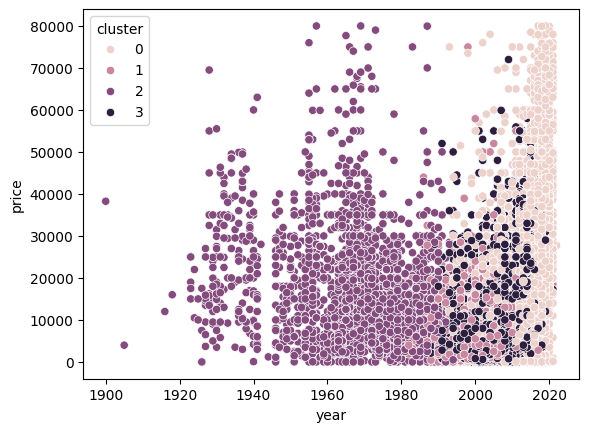

In [ ]:
kmeans = KMeans(n_clusters=6).fit(components)
cars['cluster'] = kmeans.labels_
sns.scatterplot(cars, x='year', y='price', hue='cluster')

In [ ]:
#various epsilon values
epsilons = 10**np.linspace(-2, 2, 10)
epsilons

array([1.00000000e-02, 2.78255940e-02, 7.74263683e-02, 2.15443469e-01,
       5.99484250e-01, 1.66810054e+00, 4.64158883e+00, 1.29154967e+01,
       3.59381366e+01, 1.00000000e+02])

In [ ]:
#examine the number of clusters created with 
#each epsilon value. 
#Plot the results
n_clusters_list = []
for eps in [.0001, .001, .01]:
    db = DBSCAN(eps = eps).fit(components)
    n_clusters = len(np.unique(db.labels_))
    n_clusters_list.append(n_clusters)
plt.plot(epsilons, n_clusters_list)
plt.xlabel('Epsilon')
plt.ylabel('Number of Clusters')
plt.title('How the Number of Clusters varies with eps');

In [ ]:
# DBSCAN clustering
dbscan = DBSCAN(eps=0.15, min_samples=4)
clusters = dbscan.fit_predict(components)

<Axes: xlabel='year', ylabel='price'>

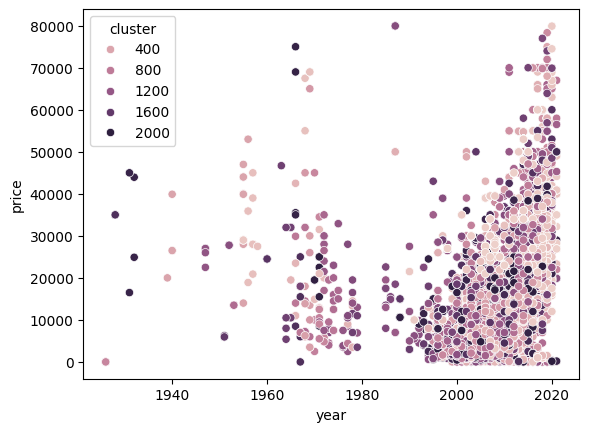

In [ ]:
cars['cluster'] = clusters
sns.scatterplot(cars.query('cluster > 0'), x='year', y='price', hue='cluster')